In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

from collections import defaultdict

In [2]:
def hough_draw_lines(img, lines):
    for i in range(lines.shape[0]):
        for rho,theta in lines[i]:
            a=np.cos(theta)
            b=np.sin(theta)
            x0=a*rho
            y0=b*rho
            x1=int(x0+1000*(-b))
            y1=int(y0+1000*(a))
            x2=int(x0-1000*(-b))
            y2=int(y0-1000*(a))
            cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)

In [3]:
def segment_by_angle_kmeans(lines, k=2, **kwargs):
    """Groups lines based on angle with k-means.

    Uses k-means on the coordinates of the angle on the unit circle 
    to segment `k` angles inside `lines`.
    """

    # Define criteria = (type, max_iter, epsilon)
    default_criteria_type = cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER
    criteria = kwargs.get('criteria', (default_criteria_type, 10, 1.0))
    flags = kwargs.get('flags', cv2.KMEANS_RANDOM_CENTERS)
    attempts = kwargs.get('attempts', 10)

    # returns angles in [0, pi] in radians
    angles = np.array([line[0][1] for line in lines])
    # multiply the angles by two and find coordinates of that angle
    pts = np.array([[np.cos(2*angle), np.sin(2*angle)]
                    for angle in angles], dtype=np.float32)

    # run kmeans on the coords
    labels, centers = cv2.kmeans(pts, k, None, criteria, attempts, flags)[1:]
    labels = labels.reshape(-1)  # transpose to row vec

    # segment lines based on their kmeans label
    segmented = defaultdict(list)
    for i, line in enumerate(lines):
        segmented[labels[i]].append(line)
    segmented = list(segmented.values())
    return segmented

In [4]:
def intersection(line1, line2):
    """Finds the intersection of two lines given in Hesse normal form.

    Returns closest integer pixel locations.
    See https://stackoverflow.com/a/383527/5087436
    """
    rho1, theta1 = line1[0]
    rho2, theta2 = line2[0]
    A = np.array([
        [np.cos(theta1), np.sin(theta1)],
        [np.cos(theta2), np.sin(theta2)]
    ])
    b = np.array([[rho1], [rho2]])
    x0, y0 = np.linalg.solve(A, b)
    x0, y0 = int(np.round(x0)), int(np.round(y0))
    return [[x0, y0]]


def segmented_intersections(lines):
    """Finds the intersections between groups of lines."""

    intersections = []
    for i, group in enumerate(lines[:-1]):
        for next_group in lines[i+1:]:
            for line1 in group:
                for line2 in next_group:
                    intersections.append(intersection(line1, line2)) 

    return intersections

In [5]:
def intersections_final(intersections):
    val = [intersections[0][0]] 

    rg = 100
    for i in range(1, len(intersections)):
        x,y = intersections[i][0]
        
        z=0
        for i in range(len(val)):
            if x-rg <= val[i][0] <= x+rg and y-rg <= val[i][1] <= y+rg:
                val[i][0] = (val[i][0]+x)/2
                val[i][1] = (val[i][1]+y)/2
                z = 1
                
        if z == 0:
            val = np.append(val,[[x,y]], axis=0)
    
    columnIndex = 0
    sortedArr = val[val[:,columnIndex].argsort()]

    if sortedArr[0][0] + sortedArr[0][1] >= sortedArr[1][0] + sortedArr[1][1]:
        sortedArr[0][0], sortedArr[1][0] = sortedArr[1][0], sortedArr[0][0]
        sortedArr[0][1], sortedArr[1][1] = sortedArr[1][1], sortedArr[0][1]

    if sortedArr[2][0] + sortedArr[2][1] >= sortedArr[3][0] + sortedArr[3][1]:
        sortedArr[3][0], sortedArr[4][0] = sortedArr[4][0], sortedArr[3][0]
        sortedArr[3][1], sortedArr[4][1] = sortedArr[4][1], sortedArr[3][1]
    
    print("4 Intersections : \n", sortedArr)
    return sortedArr

In [6]:
def transform(image, original_pts, desired_pts, title_list):
    for i in range(4):
        cv2.circle(image, tuple(original_pts[i]), 5, (0, 0, 255), -1)
    
    matrix = cv2.getPerspectiveTransform(original_pts, desired_pts)
    result = cv2.warpPerspective(image, matrix, (900, 1400))

    res_show = []
    res_show.append(image)
    res_show.append(result)
    
    fig = plt.figure(figsize=(13, 9))

    for i in range(2):
        fig.add_subplot(1,2,i+1)
        plt.title(title_list[i], fontsize=25)
        plt.imshow(cv2.cvtColor(res_show[i], cv2.COLOR_BGR2RGB))
        plt.axis('off')

    plt.tight_layout()
    plt.show()

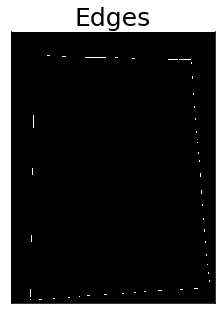

In [7]:
img=cv2.imread("paper.jpg")

gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

blur=cv2.GaussianBlur(gray,(15, 15),0)
edges=cv2.Canny(blur,10,170,apertureSize=3)

plt.figure(figsize=(5,5))
plt.subplot(111),plt.imshow(edges,cmap='gray')
plt.title('Edges', fontsize=25), plt.xticks([]), plt.yticks([])
plt.show()

In [8]:
lines=cv2.HoughLines(edges,1,np.pi/180,150)

hough_draw_lines(img, lines)

segmented = segment_by_angle_kmeans(lines)
intersections = segmented_intersections(segmented)
sort_intersections = intersections_final(intersections)

4 Intersections : 
 [[ 114  129]
 [ 112 1421]
 [ 956  154]
 [1044 1351]]


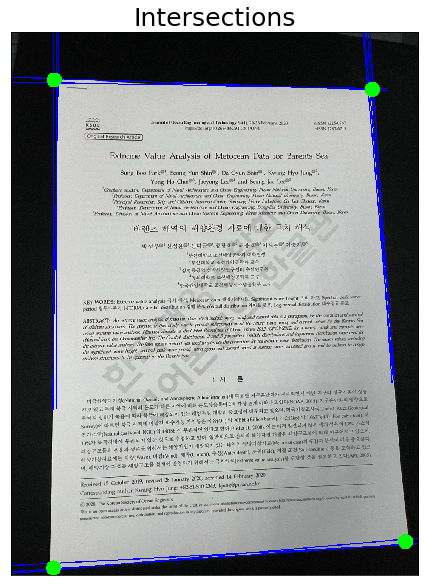

In [9]:
for i in range(len(sort_intersections)):
    x,y = sort_intersections[i]
    cv2.circle(img, (x,y),20,(0,255,0),-1)

plt.figure(figsize=(10,10))
plt.subplot(111),plt.imshow(img,cmap='gray')
plt.title('Intersections', fontsize=25), plt.xticks([]), plt.yticks([])
plt.show()

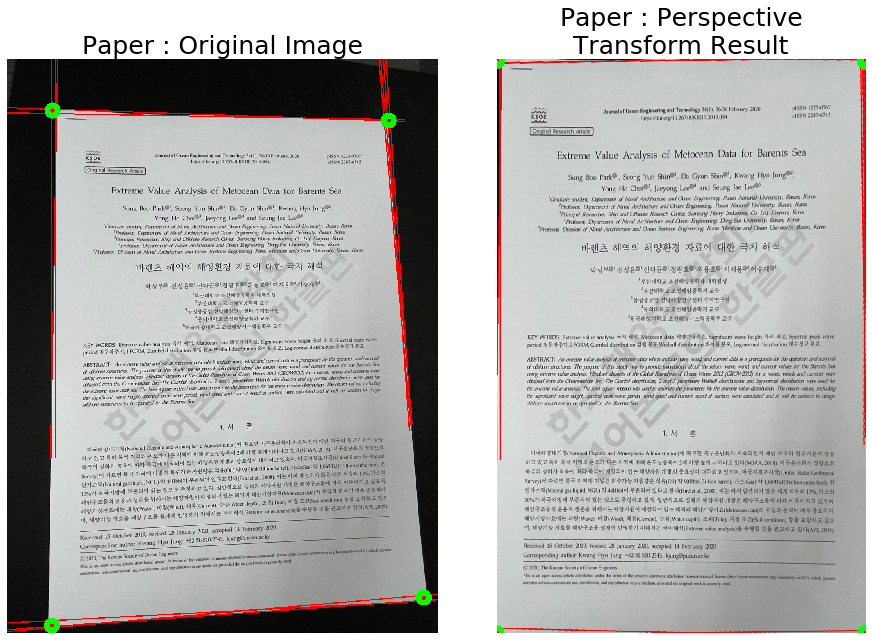

In [10]:
title_list = ['Paper : Original Image','Paper : Perspective\nTransform Result']

original_pts = np.float32([sort_intersections[0], sort_intersections[1], sort_intersections[2], sort_intersections[3]])
desired_pts = np.float32([[0, 0], [0, 1400], [900, 0], [900, 1400]])
transform(img, original_pts, desired_pts, title_list)